In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
#install many of the necessary libraries. Will typically get an error regarding "pillow". Just re run cell
import solaris as sol
import numpy as np
import pandas as pd
import geopandas as gpd
import descartes
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os
import supermercado

/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/brentsair/anaconda3/envs

In [8]:
#set the file paths for the first selected COG and labels:
region = 'acc'
zone = '665946'
train_directory = 'train_tier_1'

geojson = f'../../data/raw/{train_directory}/{region}/{zone}-labels/{zone}.geojson'
geotif = f'../../data/raw/{train_directory}/{region}/{zone}/{zone}.tif'

In [9]:
#make the directories to store processed/output data
data_dir = '../../data/processed/'
!mkdir ../../data/processed/images-256-{region}-{zone}
img_path = '../../data/processed/images-256'
!mkdir ../../data/processed/masks-256-{region}-{zone}
mask_path = '../../data/processed/masks-256'

mkdir: ../../data/processed/images-256-acc-665946: File exists
mkdir: ../../data/processed/masks-256-acc-665946: File exists


In [10]:
# load geojson for labels

label_df = gpd.read_file(geojson)
# remove empty rows
# label_df = label_df[label_df['geometry'].isna() != True] 


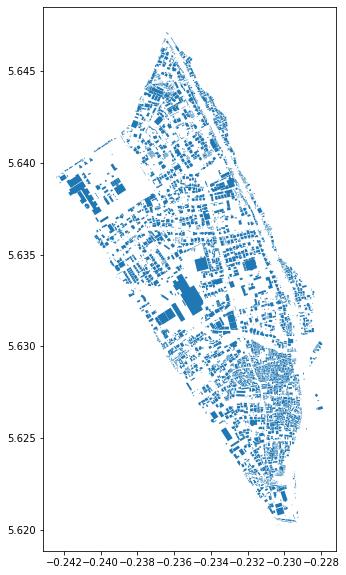

In [11]:
#visualize the polygons
label_df.plot(figsize=(10,10))

### Creat training and validation subsets of the geometry

We need the polygons and the geotif imagery to be clipped into small tiles in order to be processes and eventually fed into a a CNN. To begin with we need to take the following steps:

1. Using supermercado tile burn method to create square polygon "cells" representing all the slippy map tiles at a specified zoom level that overlap the labeled polygons. 
2. Then we seperate these cells into training and validation sets. 


### To do: 
split into the train/val sets more efficiently (i.e. not making new dfs, then re combing them.) Instead, label 20% of them as "validation" in new column "dataset" and that way is not just the southern portion of the region that is validation and the norther part that is training because this type of thing could lead to too variant senstive model. If intead the validation cells are sprinkled throughout the entire region, it will be more evenly represented and not affected by geographic interdependencies. For example in the region visualized above there are clearly smaller and more dense buildings in the southern region, and larger more sparse buildings in the northern region.  



In [12]:
#define the tile size and zoom level for the burned tiles
zoom_level = 19

In [13]:
#This bash command uses the supermercado burn tiles method to creat a new geojson of the tiles 
!cat ../../data/raw/train_tier_1/acc/665946/665946.json | supermercado burn {zoom_level} | mercantile shapes | fio collect > ../../data/raw/train_tier_1/acc/665946/trn_aoi_ztiles.geojson


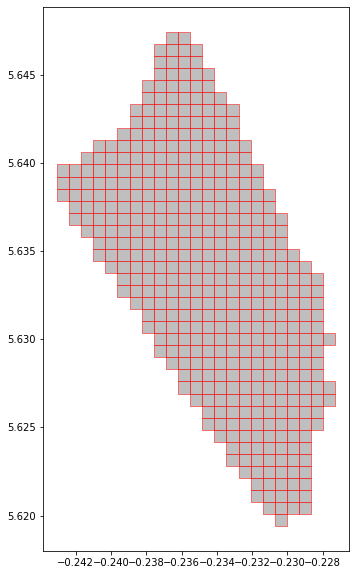

In [14]:
#import the geojson containing the tiles
trn_tiles = gpd.read_file("../../data/raw/train_tier_1/acc/665946/trn_aoi_ztiles.geojson")
trn_tiles.plot(figsize=(10,10), color='grey', alpha=0.5, edgecolor='red')

/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


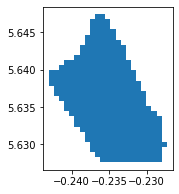

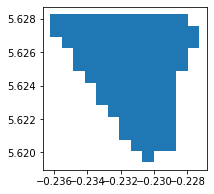

In [15]:
#get the bounds of the supermercado cells
bounds = trn_tiles.bounds

#find the coordinates for 70/30 split on y axis extent
extent = (bounds.maxy.max()-bounds.miny.min())*.7

#create the y coodinates for training and validation subsets
train_ymin = bounds.maxy.max()
train_ymax = bounds.maxy.max()-extent
val_ymax = bounds.maxy.max()-extent
val_ymin = bounds.miny.min()

#use indexing to subset the training area
train_tiles = trn_tiles.cx[:, train_ymin:train_ymax]
train_tiles.plot(figsize=(10, 3));

#use indexing to subset the validation area
val_tiles = trn_tiles.cx[:,val_ymin : val_ymax]
val_tiles.plot(figsize=(10, 3));

#create a "dataset" column for each subset
val_tiles['dataset']="validation"
train_tiles['dataset']="train"

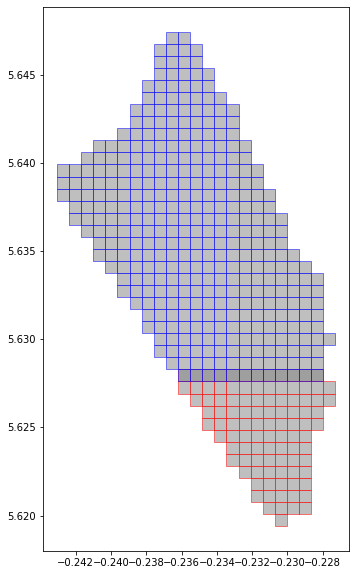

In [16]:
# see if there's overlapping tiles between trn and val

fig, ax = plt.subplots(figsize=(10,10))
val_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='red')
train_tiles.plot(ax=ax, color='grey', alpha=0.5, edgecolor='blue')

In [17]:
# merge into one gdf to keep all trn tiles while dropping overlapping/duplicate val tiles

tiles_gdf = gpd.GeoDataFrame(pd.concat([train_tiles, val_tiles], ignore_index=True), crs=trn_tiles.crs)
tiles_gdf.drop_duplicates(subset=['id'], inplace=True)

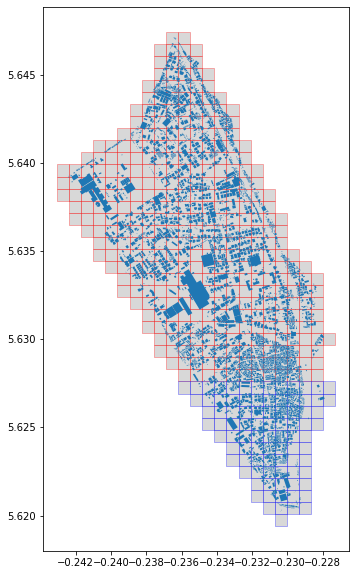

In [18]:
# check that there's no more overlapping tiles between trn and val and also project the label polygons
fig, ax = plt.subplots(figsize=(10,10))
tiles_gdf[tiles_gdf['dataset'] == 'train'].plot(ax=ax, color='grey', edgecolor='red', alpha=0.3)
tiles_gdf[tiles_gdf['dataset'] == 'validation'].plot(ax=ax, color='grey', edgecolor='blue', alpha=0.3)
label_df.plot(ax=ax)

In [19]:
# convert 'id' string to list of ints for z,x,y

def reformat_xyz(tile_gdf):
  tile_gdf['xyz'] = tile_gdf.id.apply(lambda x: x.lstrip('(,)').rstrip('(,)').split(','))
  tile_gdf['xyz'] = [[int(q) for q in p] for p in tile_gdf['xyz']]
  return tile_gdf

In [20]:
#use above funciton to create xyz column
tiles_gdf = reformat_xyz(tiles_gdf)

### Load/crop COGtiff  to the area of one of the burned tiles using rio_tiler



In [21]:
from rio_tiler import main as rt_main

import mercantile
from rasterio.transform import from_bounds
from shapely.geometry import Polygon
from shapely.ops import cascaded_union

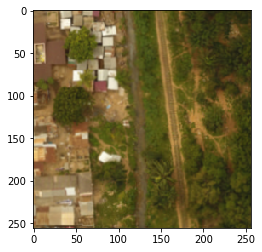

In [22]:
#define tile size. here we will use 256x256 pixel 
tile_size = 256

#Choose a random tile's id:
idx = 381

#clip the tile
tile, mask = rt_main.tile(geotif, *tiles_gdf.iloc[idx]['xyz'], tilesize=tile_size)

#display the clipped COGtif
plt.imshow(np.moveaxis(tile,0,2))

### Crop the label polygons to the area of the same tile

In [23]:
# preemptively fix and merge any invalid or overlapping geoms that would otherwise throw errors during the rasterize step. 
# TODO: probably a better way to do this

# https://gis.stackexchange.com/questions/271733/geopandas-dissolve-overlapping-polygons
# https://nbviewer.jupyter.org/gist/rutgerhofste/6e7c6569616c2550568b9ce9cb4716a3

def explode(gdf):
    """    
    Will explode the geodataframe's muti-part geometries into single 
    geometries. Each row containing a multi-part geometry will be split into
    multiple rows with single geometries, thereby increasing the vertical size
    of the geodataframe. The index of the input geodataframe is no longer
    unique and is replaced with a multi-index. 

    The output geodataframe has an index based on two columns (multi-index) 
    i.e. 'level_0' (index of input geodataframe) and 'level_1' which is a new
    zero-based index for each single part geometry per multi-part geometry
    
    Args:
        gdf (gpd.GeoDataFrame) : input geodataframe with multi-geometries
        
    Returns:
        gdf (gpd.GeoDataFrame) : exploded geodataframe with each single 
                                 geometry as a separate entry in the 
                                 geodataframe. The GeoDataFrame has a multi-
                                 index set to columns level_0 and level_1
        
    """
    gs = gdf.explode()
    gdf2 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2.merge(gdf.drop('geometry', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geometry')
    gdf_out.crs = gdf.crs
    return gdf_out

def cleanup_invalid_geoms(all_polys):
  all_polys_merged = gpd.GeoDataFrame()
  all_polys_merged['geometry'] = gpd.GeoSeries(cascaded_union([p.buffer(0) for p in all_polys]))

  gdf_out = explode(all_polys_merged)
  gdf_out = gdf_out.reset_index()
  gdf_out.drop(columns=['level_0','level_1'], inplace=True)
  all_polys = gdf_out['geometry']
  return all_polys

In [24]:
# get the geometries from the geodataframe
all_polys = label_df.geometry

all_polys = cleanup_invalid_geoms(all_polys)

(-0.229339599609375, 5.626919311742117, -0.2286529541015625, 5.627602648207712)


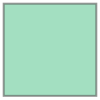

In [25]:
# get the same tile polygon as our tile image above
tile_poly = tiles_gdf.iloc[idx]['geometry']
print(tile_poly.bounds)
tile_poly

get affine transformation matrix for this tile using rasterio.transform.from_bounds: 


""" Affine transformation is a linear mapping method that preserves points, 
    straight lines, and planes. Sets of parallel lines remain parallel after an affine transformation. 
    The affine transformation technique is typically used to correct for geometric distortions or deformations that       occur with non-ideal camera angles""""

In [26]:
tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
tfm

Affine(2.682209014892578e-06, 0.0, -0.229339599609375,
       0.0, -2.6692830687319313e-06, 5.627602648207712)

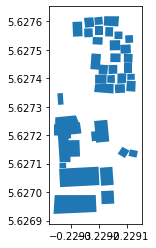

In [27]:
cropped_polys = [poly for poly in all_polys if poly.intersects(tile_poly)]
cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs={'init': 'epsg:4326'})
cropped_polys_gdf.plot()


### Use solaris to create a pixel mask

We'll create our corresponding 3-channel RGB mask by passing the cropped polygons to solaris' df_to_px_mask function. 

- 1st (Red) channel represent building footprints,
- 2nd (Green) channel represent building boundaries (visually looks yellow on the RGB mask display because the pixels overlap red and green+red=yellow),
-  3rd (Blue) channel represent close contact points between adjacent buildings

In [28]:
# burn a footprint/boundary/contact 3-channel mask with solaris: https://solaris.readthedocs.io/en/latest/tutorials/notebooks/api_masks_tutorial.html

fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)

/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


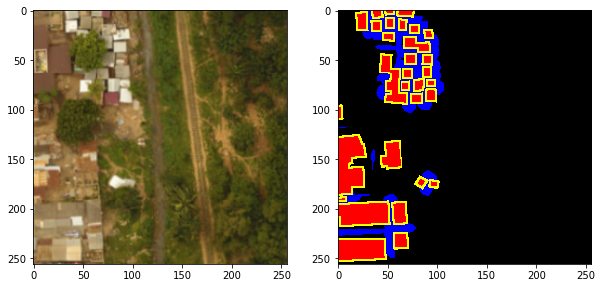

In [29]:
#visualize the new mask next to the COGtiff tile
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
ax1.imshow(np.moveaxis(tile,0,2))
ax2.imshow(fbc_mask)

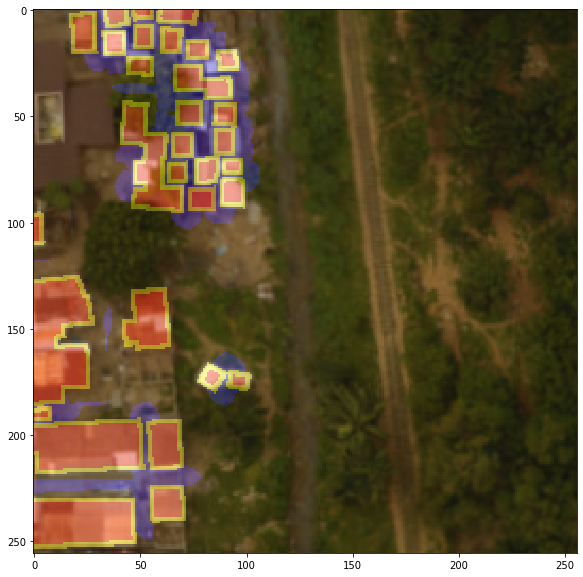

In [30]:
#visualize the new mask overlaying COGtiff tile
fig, ax = plt.subplots( figsize=(10,10))
ax.imshow(np.moveaxis(tile,0,2))
ax.imshow(fbc_mask, alpha = .3)

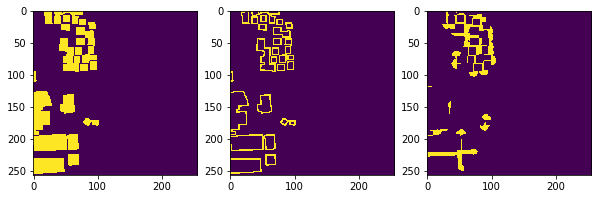

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10, 5))
ax1.imshow(fbc_mask[:,:,0])
ax2.imshow(fbc_mask[:,:,1])
ax3.imshow(fbc_mask[:,:,2])

### Clip all of the aerial imagery cells, clip all of the polygons, and rasterize all of the labels 

Combine the above process into functions in order to batch process the entire regeion. This will generate the full training and validation sets of Slippy tile cells.

In [32]:
import skimage
from tqdm import tqdm

In [ ]:
def save_tile_img(tif_url, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tile, mask = rt_main.tile(tif_url, x,y,z, tilesize=tile_size)
  if display: 
    plt.imshow(np.moveaxis(tile,0,2))
    plt.show()
    
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}.png',np.moveaxis(tile,0,2), check_contrast=False) 

In [ ]:
def save_tile_mask(labels_poly, tile_poly, xyz, tile_size, save_path='', prefix='', display=False):
  x,y,z = xyz
  tfm = from_bounds(*tile_poly.bounds, tile_size, tile_size) 
  
  cropped_polys = [poly for poly in labels_poly if poly.intersects(tile_poly)]
  cropped_polys_gdf = gpd.GeoDataFrame(geometry=cropped_polys, crs={'init': 'epsg:4326'})
  
  fbc_mask = sol.vector.mask.df_to_px_mask(df=cropped_polys_gdf,
                                         channels=['footprint', 'boundary', 'contact'],
                                         affine_obj=tfm, shape=(tile_size,tile_size),
                                         boundary_width=5, boundary_type='inner', contact_spacing=5, meters=True)
  
  if display: plt.imshow(fbc_mask); plt.show()
  
  skimage.io.imsave(f'{save_path}/{prefix}{z}_{x}_{y}_mask.png',fbc_mask, check_contrast=False) 

In [ ]:
#check the # of tiles that should result from each set:
tiles_gdf[tiles_gdf['dataset'] == 'train'].shape, tiles_gdf[tiles_gdf['dataset'] == 'validation'].shape

In [ ]:
# TODO: try loading from url and catch i/o exceptions


#Functionalize this so I can iterate through all regions 

#TODO: When training model on WHOLE dataset (all regions) load from URL, batch process (clip all of the tiles), save
#the tiles to Google Drive, then dump the COG and the original label geometry so that I don't have to store both the raw and the processed data. 

#cool things to remember about this loop:
    #1. tqdm creats a progress bar for the loop
    #2. .iterrows makes it easy to iterate through a Dataframe
    

#remember: geotif, img_path, region, zone are defined at the top of notebook when data is first imported
    
for idx, tile in tqdm(tiles_gdf.iterrows()):
    dataset = tile['dataset']
    save_tile_img(geotif, tile['xyz'], tile_size, save_path=img_path, prefix=f'{region}{zone}{dataset}_', display=False)
    

In [ ]:
#the save_tile_mask fucntion throws a bunch of warnings. figure out how to surpress these warnings using:
#warnings.filterwarnings("ignore")s.simplefilter("ignore")
#somewhere in the save_tile_mask function 


# TODO: multiprocess this? 
for idx, tile in tqdm(tiles_gdf.iterrows()):
  dataset = tile['dataset']
  tile_poly = tile['geometry']
  save_tile_mask(all_polys, tile_poly, tile['xyz'], tile_size, save_path=mask_path,prefix=f'{region}{zone}{dataset}_', display=False)


### Check that the labels and COG cells saved correctly and that the label masks are burned:

In [ ]:
#use glob to put all of the file names into a dataframe for easy access 
import glob

ims = glob.glob('../../data/processed/images-256/*.png')
df_filepaths = pd.DataFrame({
    'img_path':ims,
    'mask_path':[im.replace('images', 'masks').replace('.png', '_mask.png') for im in ims]
})
df_filepaths.head()

In [ ]:
#iterate through the dataframe and visualize a few cells and masks

start_idx, end_idx = 200,205 #choose random 5 index numbers to check 

for i in range(start_idx, end_idx):
    image, mask = df_filepaths.iloc[i]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.imshow(skimage.io.imread(image))
    ax2.imshow(skimage.io.imread(mask))
    plt.show()
        

In [ ]:
#NOTE: the above region's total cells make up ~53 mb of data: 49 from the COG tiles and 3 from the masks. This makes
# it seem way more possible to just have everything on my local machine. 

#That being said, can mount drive and save all of the tiles to google drive if run the following:

# # compress and download
# !tar -czf znz001trn.tar.gz data

# #save to drive
# from google.colab import drive
# drive.mount('/content/drive')

### Fast.ai

In [ ]:
# !curl https://course.fast.ai/setup/colab | bash

In [1]:
from fastai.vision import *
import fastai.callbacks  
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python       : 3.7.6
fastai       : 1.0.60
fastprogress : 0.2.2
torch        : 1.3.1
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-17.7.0-x86_64-i386-64bit
conda env    : solaris
python       : /Users/brentsair/anaconda3/envs/solaris/bin/python
sys.path     : /Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings/notebooks/exploratory
/usr/local/Cellar/apache-spark/2.4.4/libexec/python
/python
/Users/brentsair/Documents/Flatiron_School.nosync/SegmentingBuildings/notebooks/exploratory
/Users/brentsair/anaconda3/envs/solaris/lib/python37.zip
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/lib-dynload

/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages
/Users/brentsair/anaconda3/envs/solaris/lib/python3.7/site-packages/IPython/extensions
/Users/brentsair/.ipython
no supported gpus found on th